In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score  
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Importing the datasets

In [34]:
train = pd.read_csv('house-prices-advanced/train.csv') # importing the dataset
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [35]:
test = pd.read_csv('house-prices-advanced/test.csv') # importing the dataset
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Taking a look at the housing dataset, we see..

In [36]:
print(f"{len(train)/(len(train)+len(test)):.4f}% testing data\n{len(test)/(len(train)+len(test)):.2f}% training data")

0.5002% testing data
0.50% training data


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Model0 on raw data

Without the categorical features, using only the numeric features without any preprocessing

In [38]:
model0_train = train.drop(columns=train.select_dtypes(include = "object").columns, axis=1)
model0_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


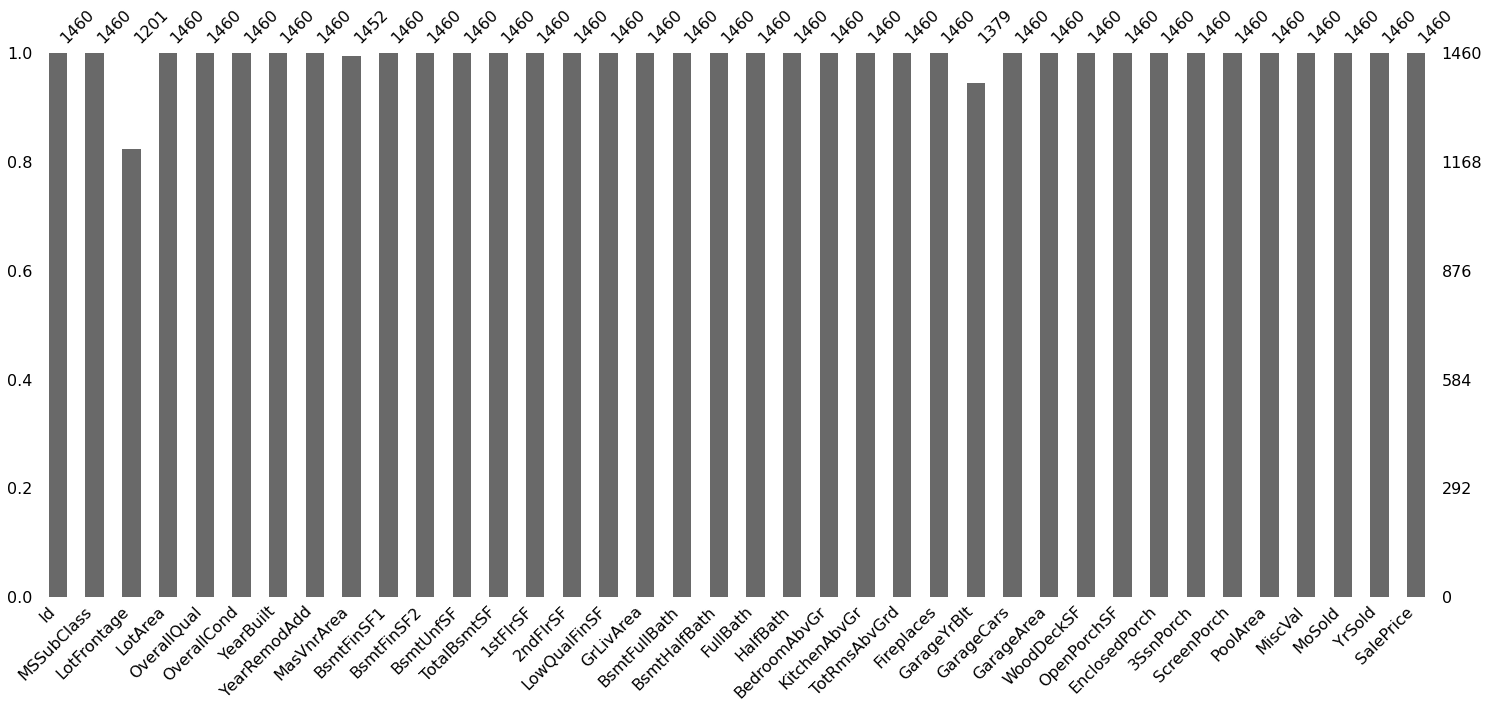

In [39]:
msno.bar(model0_train)

- We see that **LotFrontage** and **GarageYrBlt** are both containing NaN and this would result in runtime error during regression prediction.
- So, filling NA values with the median values for those columns

In [40]:
model0_train[['LotFrontage','GarageYrBlt']].describe()

,LotFrontage,GarageYrBlt
count,1201.000000,1379.000000
mean,70.049958,1978.506164
std,24.284752,24.689725
min,21.000000,1900.000000
25%,59.000000,1961.000000
50%,69.000000,1980.000000
75%,80.000000,2002.000000
max,313.000000,2010.000000


In [41]:
model0_train = model0_train.fillna(model0_train.mode().iloc[0,:])

### Train-Test Split

In [42]:
seed = 483 # found experimentally at the end
X = model0_train.drop(columns=['SalePrice','Id'],axis=1) # features 
y = model0_train['SalePrice'] # target
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.2, 
                                                        random_state = seed)

### Scaling

In [43]:
scaler=StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.073375,-0.146189,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777
1,-0.872563,0.524992,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439
2,0.073375,-0.011953,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777
3,0.309859,-0.369915,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655
4,0.073375,0.703973,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777


### Linear Regression

In [44]:
model0=LinearRegression()
model0.fit(X_train, y_train)
print(f'The accuracy for Model0 is : {model0.score(X_test, y_test):.4f}')

The accuracy for Model0 is : 0.5259


The baseline accuracy without considering the categorical data for the house price prediction is about **53%**

# Cleaning the data before training Linear Regression model

## PreProcessing

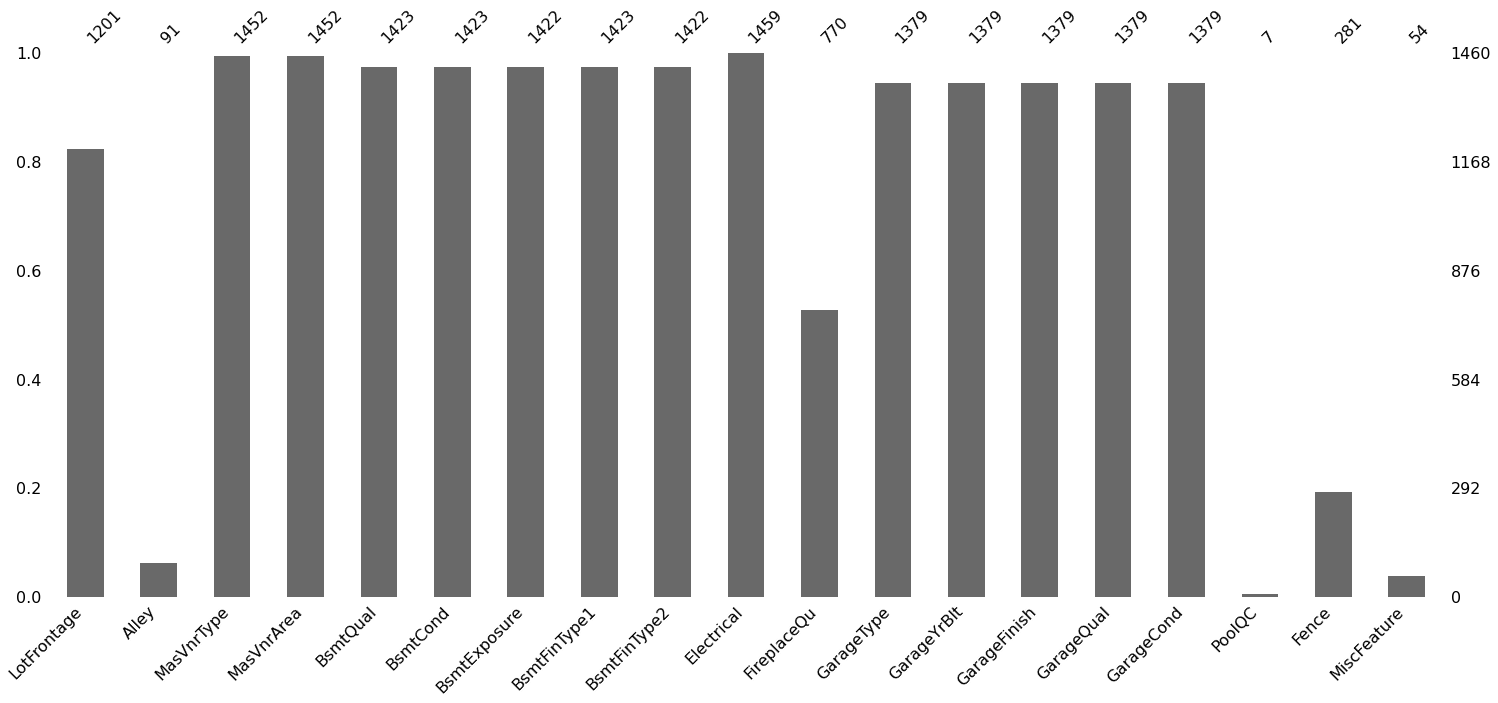

In [45]:
cols = train.columns
# train cols[]
null_cols_train = train[ # train with the columns have more than one null
    cols[  # mask the columns having more than one null
        [np.any( # If any of them is Truly NaN, captures that colm, in another boolean array
            train[col] # returns array of [True/False]
            .isnull()
        ) for col in cols]
    ]
]
msno.bar(null_cols_train) # Visualizing how many are NULL of each column

Taking 80% as the minimum threshold value for keeping a column,we see that **Alley**, **FireplaceQu**, **PoolQC**, **Fence**, **MiscFeature** fall way below the threshold, and are thus removed.

In [46]:
train_cols_cleaned = train.drop(columns=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

Now checking the correlations between the missing values among the columns in modified training data

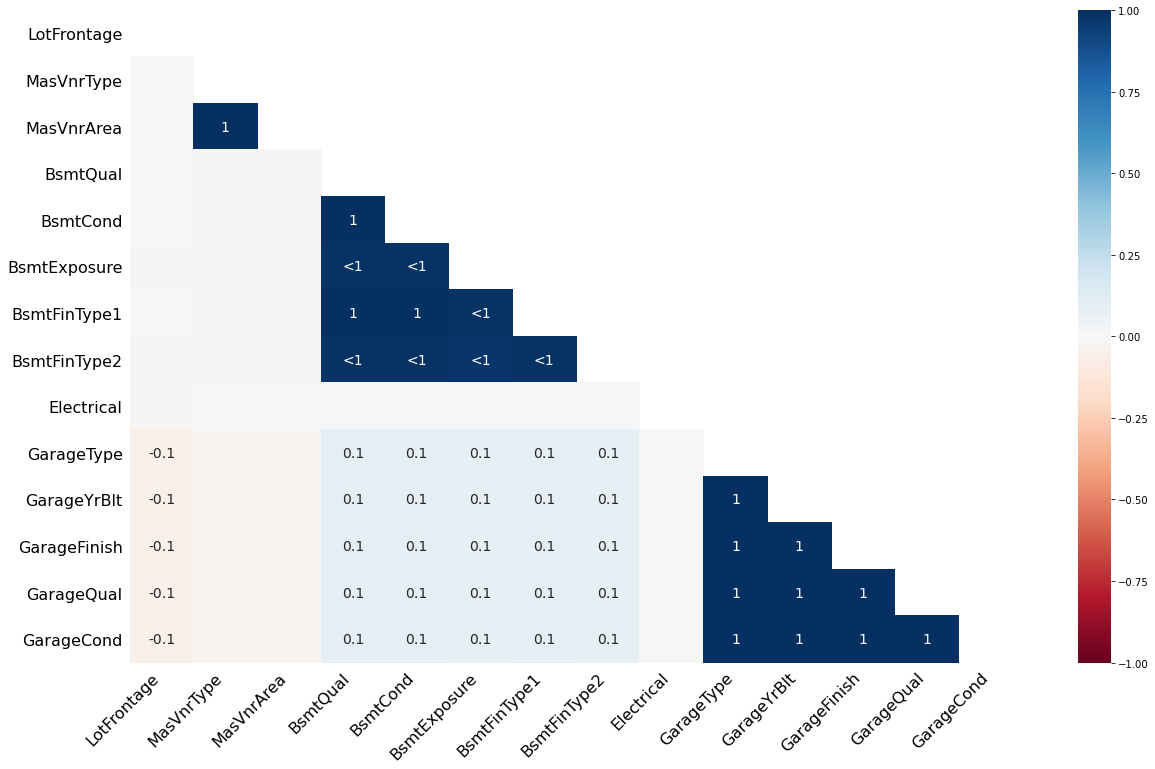

In [47]:
msno.heatmap(train_cols_cleaned)

We find that among the columns, **even the missing values are related**, thus we take high confidence that we can remove these rows and there will be lesser loss in total datapoints used for training, instead of removing all the rows with any null entry.

In [48]:
correlated_null_cols = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
n = len(train_cols_cleaned)
train_all_null_cleaned = train_cols_cleaned.dropna()
train_null_row_col_cleaned = train_cols_cleaned.dropna(subset = correlated_null_cols)
m = len(train_null_row_col_cleaned)
k = len(train_all_null_cleaned)
print(f'Removing all nan columns; Data Loss: {((n-k)/n)*100:.4f}%')
print(f'Only removing correlated columns; Data Loss: {((n-m)/n)*100:.4f}%') # Going ahead with "train_null_row_col_cleaned"

Removing all nan columns; Data Loss: 25.0685%
Only removing correlated columns; Data Loss: 7.7397%


In [49]:
cols = train_null_row_col_cleaned.columns
_ =train_null_row_col_cleaned[
        cols[
            [np.any(
                train_null_row_col_cleaned[col]
                .isnull()
            ) for col in cols]
        ]
    ].select_dtypes(include='object').columns
print(f'{list(_)} are the only categorical columns that have null values')

['MasVnrType', 'Electrical'] are the only categorical columns that have null values


In [50]:
train_null_row_col_cleaned[['MasVnrType', 'Electrical']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1347 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   MasVnrType  1339 non-null   object
 1   Electrical  1346 non-null   object
dtypes: object(2)
memory usage: 31.6+ KB


We'll fill the rest of the data using Mode values, since it can be used for both categorical and numerical cols

In [51]:
train_null_row_col_cleaned.mode().iloc[0,:] # Finding the mode for all columns

Id                      1
MSSubClass           20.0
MSZoning               RL
LotFrontage          60.0
LotArea            9600.0
                   ...   
MoSold                6.0
YrSold             2009.0
SaleType               WD
SaleCondition      Normal
SalePrice        140000.0
Name: 0, Length: 76, dtype: object

In [52]:
train_cleaned = train_null_row_col_cleaned.fillna(train_null_row_col_cleaned.mode().iloc[0,:])

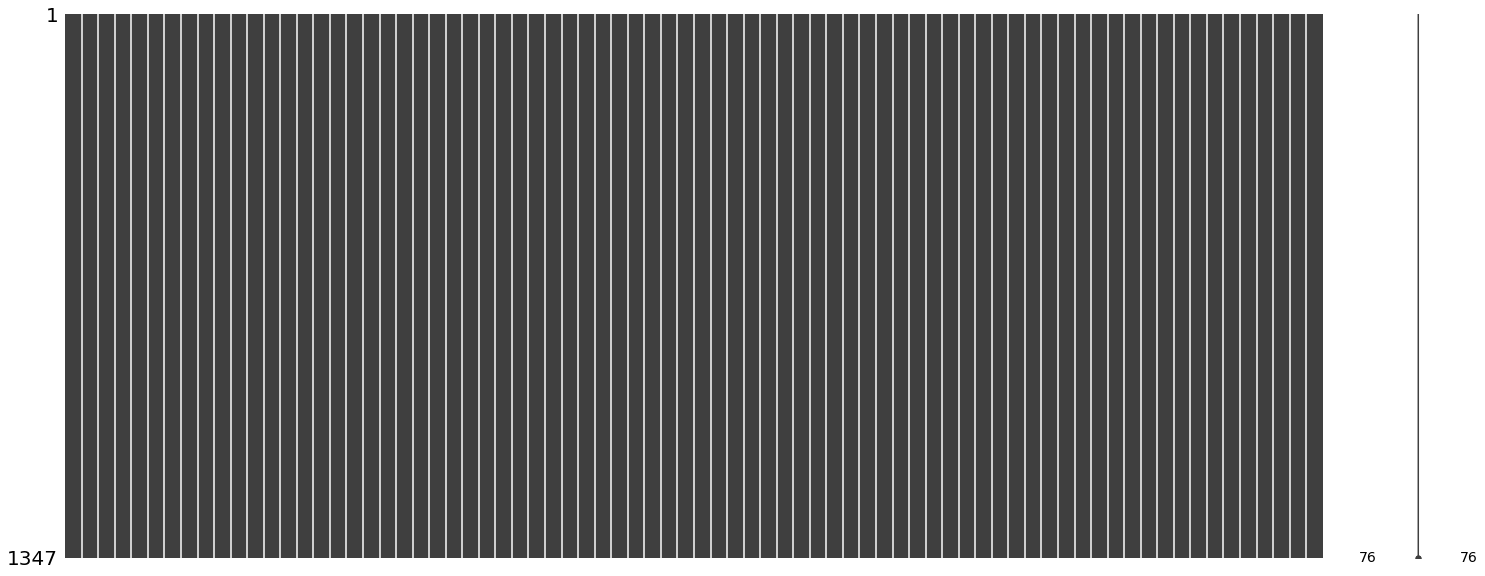

In [53]:
msno.matrix(train_cleaned)

### Label Encoding
- We need to convert string cols to ordinal cols to be able to use their values in regression
- As we will see, this dataset has majority string field columns, and hence we choose Label Encoding for getting a practical runtime, otherwise there'll be ``38*k + 76`` columns, where constant ``k > 1``

In [54]:
print(f'Number of Categorical Features: {len(train_cleaned.select_dtypes(include = "object").columns)}')
cat_cols = train_cleaned.select_dtypes(include = "object").columns

Number of Categorical Features: 38


Now that we have the reduced dataset with least possible null values, we convert the **38 out of 75** (majority) columns into Ordinal columns using Label Encoding

In [55]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_cleaned_oe = train_cleaned.copy()
for col in cat_cols:
    train_cleaned_oe[col] = oe.fit_transform(train_cleaned_oe[col].astype(str).to_numpy().reshape(-1,1))
train_cleaned_oe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1347 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1347 non-null   int64  
 1   MSSubClass     1347 non-null   int64  
 2   MSZoning       1347 non-null   float64
 3   LotFrontage    1347 non-null   float64
 4   LotArea        1347 non-null   int64  
 5   Street         1347 non-null   float64
 6   LotShape       1347 non-null   float64
 7   LandContour    1347 non-null   float64
 8   Utilities      1347 non-null   float64
 9   LotConfig      1347 non-null   float64
 10  LandSlope      1347 non-null   float64
 11  Neighborhood   1347 non-null   float64
 12  Condition1     1347 non-null   float64
 13  Condition2     1347 non-null   float64
 14  BldgType       1347 non-null   float64
 15  HouseStyle     1347 non-null   float64
 16  OverallQual    1347 non-null   int64  
 17  OverallCond    1347 non-null   int64  
 18  YearBuil

### Train Test Split of Cleaned data

In [56]:
y = train_cleaned_oe['SalePrice'] # Target
X = train_cleaned_oe.drop(columns=['SalePrice','Id'],axis=1) # Features

Scaling the feature vectors

In [57]:
scaler=StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.094627,-0.030671,-0.169210,-0.219493,0.061039,0.771219,0.307776,-0.027257,0.611919,-0.227499,...,0.197840,-0.349638,-0.118285,-0.28218,-0.071529,-0.084251,-1.604315,0.145818,0.317818,0.182317
1,-0.876515,-0.030671,0.496850,-0.108038,0.061039,0.771219,0.307776,-0.027257,-0.615564,-0.227499,...,-0.732717,-0.349638,-0.118285,-0.28218,-0.071529,-0.084251,-0.494016,-0.606738,0.317818,0.182317
2,0.094627,-0.030671,-0.035998,0.051876,0.061039,-1.344528,0.307776,-0.027257,0.611919,-0.227499,...,-0.092006,-0.349638,-0.118285,-0.28218,-0.071529,-0.084251,0.986383,0.145818,0.317818,0.182317
3,0.337412,-0.030671,-0.391230,-0.112884,0.061039,-1.344528,0.307776,-0.027257,-1.843048,-0.227499,...,-0.198791,4.121467,-0.118285,-0.28218,-0.071529,-0.084251,-1.604315,-1.359294,0.317818,-3.595857
4,0.094627,-0.030671,0.674467,0.343597,0.061039,-1.344528,0.307776,-0.027257,-0.615564,-0.227499,...,0.548705,-0.349638,-0.118285,-0.28218,-0.071529,-0.084251,2.096682,0.145818,0.317818,0.182317


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=483)
model=LinearRegression()
model.fit(X_train, y_train)
print(f'The accuracy of our new Model is : {model.score(X_test, y_test)}')

The accuracy of our new Model is : 0.8935941669745997


# Creating the model for submission

In [59]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Applying same preprocessing steps to the test data

In [60]:
test_cols_cleaned = test.drop(columns=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1) # drop columns
test_cleaned = test_cols_cleaned.fillna(test_cols_cleaned.mode().iloc[0,:]) # Fill na values with the mode for all columns

cat_cols = test_cleaned.select_dtypes(include = "object").columns # Find the categorical cols
test_cleaned_oe = test_cleaned.copy() # use label encoding to transform the test data into label encoding
for col in cat_cols: 
    test_cleaned_oe[col] = oe.transform(test_cleaned_oe[col].astype(str).to_numpy().reshape(-1,1))

X = test_cleaned_oe.drop(columns=['Id'],axis=1) # Features
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

array([150074.63955849, 182491.91199701, 195972.49454894, ...,
       185918.9877614 , 127454.11635244, 265541.58456332])

In [64]:
df = pd.DataFrame()
df['Id'] = test['Id'] 
df['SalePrice'] = model.predict(X)
df.to_csv('house-prices-advanced/submission_sample_model.csv', index=False)

# Using whole Training data

In [65]:
y = train_cleaned_oe['SalePrice'] # Target
X = train_cleaned_oe.drop(columns=['SalePrice','Id'],axis=1) # Features

scaler=StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()
model=LinearRegression()
model.fit(X_train, y_train)
print(f'The accuracy of our new Model is : {model.score(X_test, y_test)}')

The accuracy of our new Model is : 0.8935941669745997


In [69]:
test_cols_cleaned = test.drop(columns=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1) # drop columns
test_cleaned = test_cols_cleaned.fillna(test_cols_cleaned.mode().iloc[0,:]) # Fill na values with the mode for all columns

cat_cols = test_cleaned.select_dtypes(include = "object").columns # Find the categorical cols
test_cleaned_oe = test_cleaned.copy() # use label encoding to transform the test data into label encoding
for col in cat_cols: 
    test_cleaned_oe[col] = oe.transform(test_cleaned_oe[col].astype(str).to_numpy().reshape(-1,1))

X = test_cleaned_oe.drop(columns=['Id'],axis=1) # Features
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

df = pd.DataFrame()
df['Id'] = test['Id']
df['SalePrice'] = model.predict(X)
df.to_csv('house-prices-advanced/submission.csv', index=False)